# Obtain spatial resolved grain maps of PARADIM-2 in the slit beam

In [1]:
%run -i ../tomography/utils.py

In [2]:
%run -i startup3.py

## Extract the peak positions

### Load and reformat the data

`db_raw` is the databroker database.

In [6]:
sel_row = df_uid.loc[1]
sel_row

uid       5959b25f-fcfc-4ec2-9187-7d8bce19711d
sample                               PARAMID-2
task               a coarse grid rocking curve
beam                                      slit
Name: 1, dtype: object

In [7]:
run = db_raw[sel_row['uid']]
data = reformat_data(run.xarray_dask())
image_data = data["dexela_image"]

In [8]:
data

<xarray.Dataset>
Dimensions:               (dim_0: 1, dim_1: 3888, dim_2: 3072, frame: 4525)
Coordinates:
  * frame                 (frame) int64 0 1 2 3 4 5 ... 4520 4521 4522 4523 4524
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total   (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image          (frame, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
    mXBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mXBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [9]:
del sel_row

### Filter the images

We filter the images according to the `dexela_stats1_total` which is the sum of intensity on the image. The powder diffraction image has much higher intensity than the single crystal diffraction image and the air scattering image.

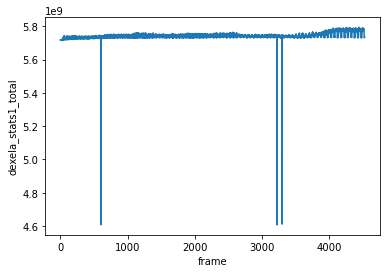

In [14]:
image_sum_data = data['dexela_stats1_total'].compute()
image_sum_data.plot();

If row >= `start_index`, the frames are all from the single crystal diffraction images. We can use the frame index of them to select the valid images.

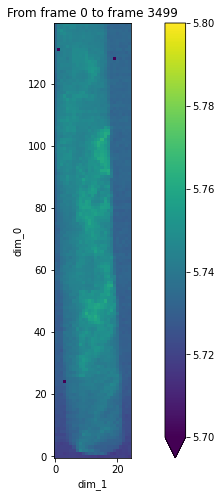

In [59]:
select_frames(image_sum_data / 1e9, run.start, start_row=0, end_row=140, vmin=5.7, vmax=5.8)

Filter out the extremely low intensity frames.

In [60]:
sel_image_sum_data = image_sum_data[0:3499 + 1]
sel_image_sum_data = sel_image_sum_data[sel_image_sum_data / 1e9 > 5.6]

### Run again with the filtered images

Get the maximum and minimum of pixel values for the images of the non-powder part.

In [66]:
sel_image_data = image_data[sel_image_sum_data.frame.values]
shadows = min_and_max_along_time(sel_image_data)
shadows = shadows.astype(np.int16)

In [67]:
db_cdf.insert(shadows.to_dataset(name="shadow"), dict(**run.start, tag="max and min frame"))

'60c9246507de20d7d30c65fb'

In [70]:
del shadows

### Visualize the averaged light and dark frame

In [77]:
shadows = db_cdf.get_data("60c9246507de20d7d30c65fb")["shadow"]

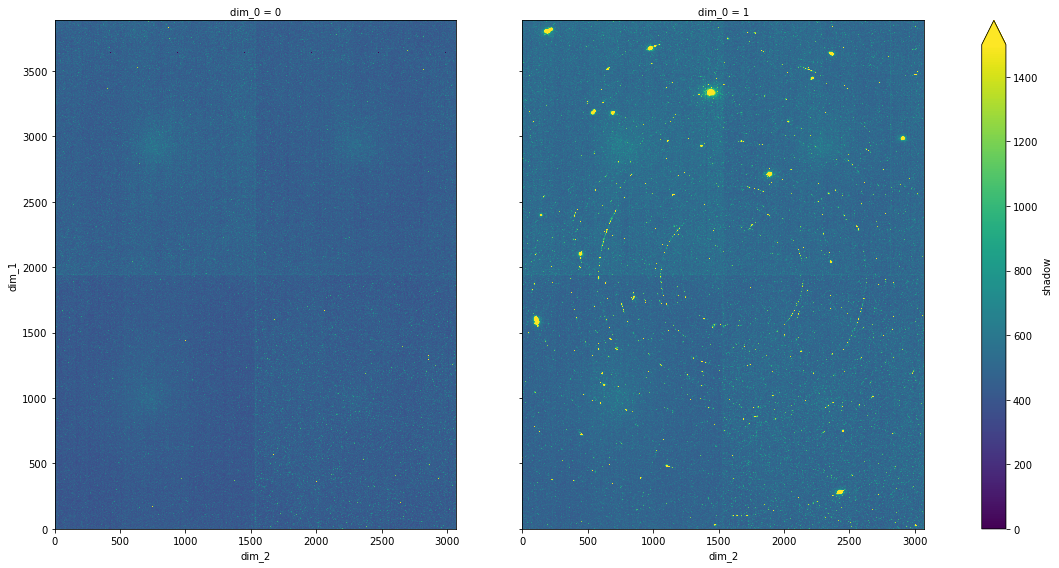

In [78]:
facet = shadows.plot(col="dim_0", size=8, vmax=1500)
set_real_aspect(facet.axes)

The result shows all the shinning points that ever appeared in any of the frames. Some look like Bragg peaks while the other look like a part of powder diffraction rings.

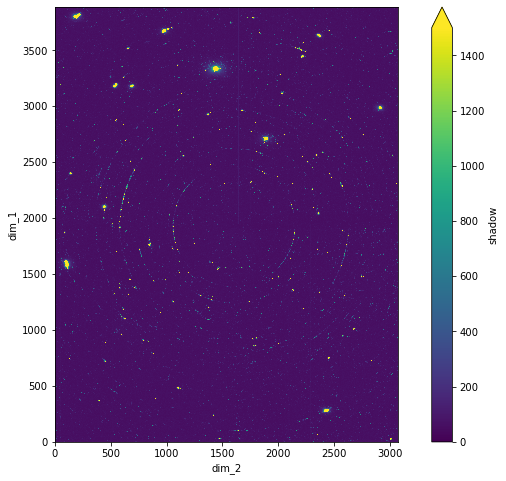

In [79]:
subtracted_shadow = shadows[1] - shadows[0]
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)

## Locate the peak positions and track it

### Locate the spots

Use `trackpy.locate` to find the spots on the image.

In [83]:
df = tp.locate(subtracted_shadow.values, diameter=51, percentile=67., engine="numba", threshold=600, minmass=2000)
df

,y,x,mass,size,ecc,signal,raw_mass,ep
0,26.314320,3005.694697,1.059536e+06,4.001228,0.116849,15309.586524,1344580.0,0.013653
1,29.971795,1473.259891,2.408881e+05,4.173043,0.281693,4066.219408,478687.0,0.047219
2,101.957490,1642.746887,4.095706e+05,3.171995,0.041408,14162.390557,623744.0,0.033445
3,265.988248,2291.497312,2.589587e+04,1.296267,0.371294,3998.958636,158269.0,0.523250
4,281.412976,2430.829704,6.223657e+06,10.915028,0.322648,12259.334025,10176421.0,0.001655
...,...,...,...,...,...,...,...,...
134,3518.478260,654.312845,1.835639e+06,5.300319,0.197440,14991.626510,2371828.0,0.007407
135,3634.643082,2362.653486,5.003391e+06,10.958328,0.462474,13218.387972,7371067.0,0.002296
136,3674.606249,977.708523,5.627975e+06,9.763818,0.284177,12541.076700,8868567.0,0.001902
137,3790.331699,1779.328843,5.137326e+05,4.679503,0.322804,12485.104449,742576.0,0.026994


In [84]:
db_csv.insert(df, dict(**run.start, tag="located features on the shadow image"))

'60c931f307de20d7d30c65fc'

In [85]:
del df

### Select the ones to track

We select the 20 largest peaks to track.

In [93]:
peaks = db_csv.get_data("60c931f307de20d7d30c65fc")
peaks = peaks.sort_values("mass", ascending=False).iloc[:20]
windows = create_windows_from_width(peaks, 50)

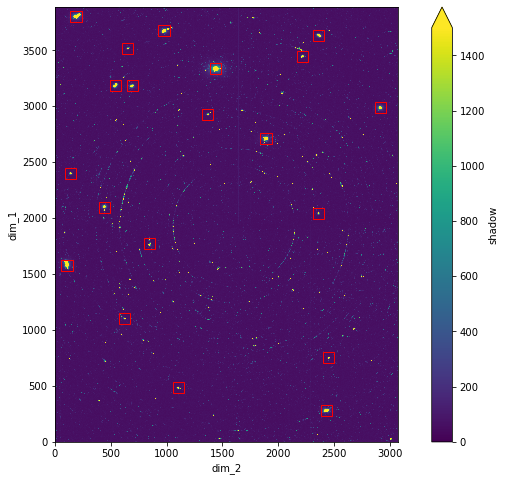

In [94]:
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)
draw_windows(windows, facet.axes)
plt.show()

In [95]:
del facet

### Run the tracking

In [97]:
grains = create_grain_maps(image_data, windows, run.start)

In [ ]:
db_cdf.insert(grains, dict(**run.start, tag="grain maps"))

'60c949ff07de20d7d30c65fd'

In [100]:
del grains

### Visualize the grain maps

This is the final result of 20 grain maps. They are visualized in a log scale color map.

In [3]:
grains = db_cdf.get_data("60c949ff07de20d7d30c65fd")
grains = grains.set_index({"grain": ["x", "y"]})
grains

<xarray.Dataset>
Dimensions:  (dim_0: 181, dim_1: 25, grain: 20)
Coordinates:
  * dim_0    (dim_0) float64 45.0 44.75 44.5 44.25 44.0 ... 0.75 0.5 0.25 0.0
  * dim_1    (dim_1) float64 6.0 5.75 5.5 5.25 5.0 ... 1.0 0.75 0.5 0.25 0.0
  * grain    (grain) MultiIndex
  - x        (grain) int64 1442 191 111 2431 543 978 ... 2359 1104 1370 852 626
  - y        (grain) int64 3336 3805 1581 281 3187 ... 2042 483 2929 1770 1102
Data variables:
    maps     (grain, dim_0, dim_1) float64 516.8 517.9 516.6 ... 506.4 507.1
    dx       (grain) int32 50 50 50 50 50 50 50 50 ... 50 50 50 50 50 50 50 50
    dy       (grain) int32 50 50 50 50 50 50 50 50 ... 50 50 50 50 50 50 50 50

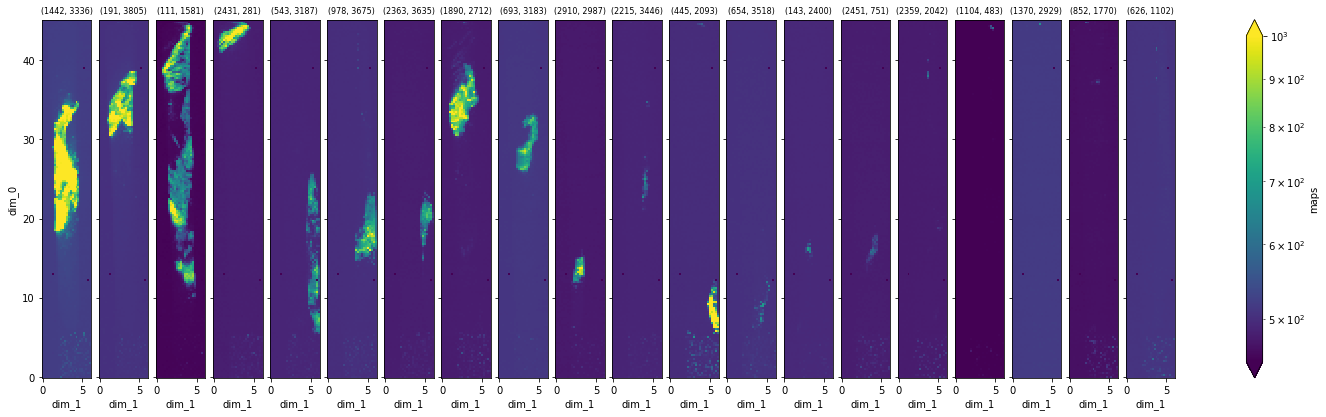

In [164]:
facet = plot_grain_maps(grains, norm=mpl.colors.LogNorm(vmin=450, vmax=1000))
facet.set_titles(template="{value}", size=8)
del facet

### Compare it with the one from the focus beam

In [54]:
grains2 = db_cdf.get_data("60ca20090ea9000d07b715ff")
grains2 = grains2.set_index({"grain": ["x", "y"]})
grains2

<xarray.Dataset>
Dimensions:  (dim_0: 181, dim_1: 27, grain: 20)
Coordinates:
  * dim_0    (dim_0) float64 0.0 0.25 0.5 0.75 1.0 ... 44.25 44.5 44.75 45.0
  * dim_1    (dim_1) float64 6.5 6.25 6.0 5.75 5.5 ... 1.0 0.75 0.5 0.25 0.0
  * grain    (grain) MultiIndex
  - x        (grain) int64 195 1447 986 115 548 2435 ... 449 113 2358 861 634
  - y        (grain) int64 3832 3363 3703 1607 3214 ... 2131 1721 1750 1803 1122
Data variables:
    maps     (grain, dim_0, dim_1) float64 503.3 503.8 503.4 ... 507.0 506.2
    dx       (grain) int32 58 48 54 57 46 53 40 39 ... 24 23 20 20 16 16 30 15
    dy       (grain) int32 58 48 54 57 46 53 40 39 ... 24 23 20 20 16 16 30 15

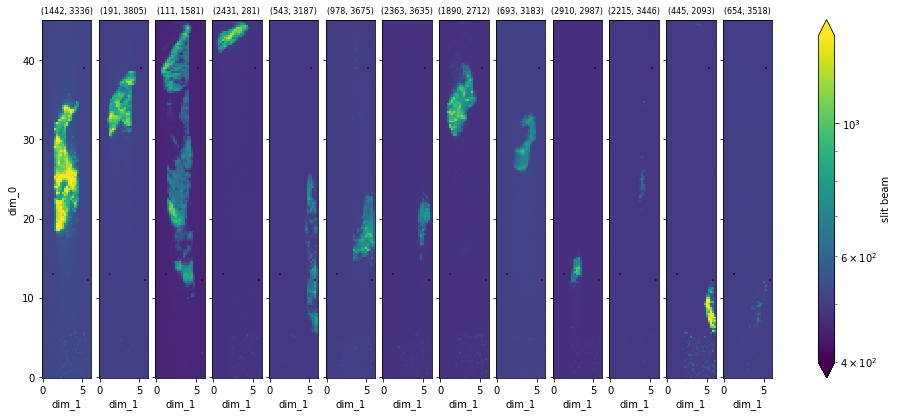

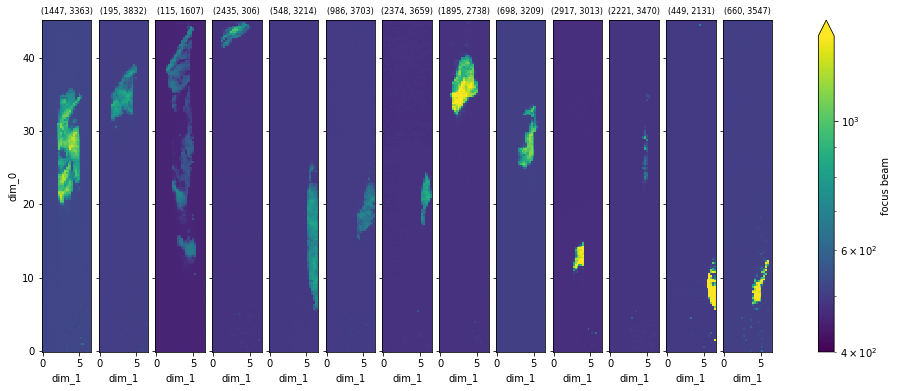

In [64]:
grain_id_map = [1, 0, 3, 5, 4, 2, 7, 8, 9, 10, 11, 15, 13]
sel_grains = grains["maps"][:13]
sel_grains.name = "slit beam"
sel_grains2 = grains2["maps"][grain_id_map]
sel_grains2.name = "focus beam"

facet = plot_along_grains(sel_grains, norm=mpl.colors.LogNorm(vmin=400, vmax=1400))
facet.set_titles(template="{value}", size=8)

facet2 = plot_along_grains(sel_grains2, norm=mpl.colors.LogNorm(vmin=400, vmax=1400))
facet2.set_titles(template="{value}", size=8)

del facet, facet2

### The mean of the grain maps

It shows the total distribution of all 20 grains.

In [155]:
mean_map = grains["maps"].mean(dim="grain")

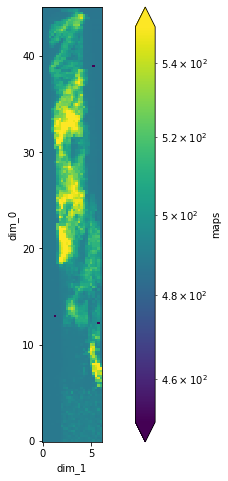

In [163]:
facet = mean_map.plot.pcolormesh(size=8, norm=mpl.colors.LogNorm(vmin=450, vmax=550))
set_real_aspect(facet.axes)